<a href="https://colab.research.google.com/github/Hrithik2212/CV-for-Self-Driving-Car/blob/main/01_Vehicle_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!nvidia-smi

Sat Sep 17 15:21:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Data Wrangling 

In [2]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json

kaggle.json


In [3]:
dataset_url="alincijov/self-driving-cars"
dataset_name=dataset_url.split("/")[1]
!kaggle datasets download -d  {dataset_url}
!mkdir {dataset_name}
!unzip -q {dataset_name}.zip -d {dataset_name}
!rm -f {dataset_name}.zip

 99% 881M/892M [00:26<00:00, 32.8MB/s]
100% 892M/892M [00:26<00:00, 35.1MB/s]


## Data Exploration and Preparation 

In [ ]:
!pip install torch-snippets
!pip install selectivesearch

In [5]:
import warnings
warnings.filterwarnings("ignore")
import torch
from torch_snippets import *
import glob
from google.colab import files
from torchvision import transforms, models, datasets
from torch_snippets import Report
from torchvision.ops import nms

In [26]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device 

'cuda'

In [19]:
df = pd.read_csv('/content/self-driving-cars/labels_train.csv')
df.head()

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3
2,1478019953180167674.jpg,218,231,146,158,1
3,1478019953689774621.jpg,171,182,141,154,2
4,1478019953689774621.jpg,179,191,144,155,1


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132406 entries, 0 to 132405
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   frame     132406 non-null  object
 1   xmin      132406 non-null  int64 
 2   xmax      132406 non-null  int64 
 3   ymin      132406 non-null  int64 
 4   ymax      132406 non-null  int64 
 5   class_id  132406 non-null  int64 
dtypes: int64(5), object(1)
memory usage: 6.1+ MB


In [63]:
for col in ['xmin', 'ymin' ,'xmax' ,'ymax']:
  df[col] = df[col].astype(np.float64)

In [64]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132406 entries, 0 to 132405
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   frame     132406 non-null  object 
 1   xmin      132406 non-null  float64
 2   xmax      132406 non-null  float64
 3   ymin      132406 non-null  float64
 4   ymax      132406 non-null  float64
 5   class_id  132406 non-null  int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 6.1+ MB


In [10]:
df.describe()

,xmin,xmax,ymin,ymax,class_id
count,132406.000000,132406.000000,132406.000000,132406.000000,132406.000000
mean,202.112223,235.400118,133.525376,162.240148,1.624692
std,114.647213,116.401491,20.508451,28.585448,1.269443
min,0.000000,3.000000,0.000000,0.000000,1.000000
25%,118.000000,150.000000,131.000000,152.000000,1.000000
50%,200.000000,224.000000,139.000000,160.000000,1.000000
75%,280.000000,312.000000,143.000000,171.000000,1.000000
max,475.000000,479.000000,275.000000,299.000000,5.000000


In [11]:
df.columns

Index(['frame', 'xmin', 'xmax', 'ymin', 'ymax', 'class_id'], dtype='object')

In [12]:
labels = { 0:'backgroud',
          1:'car',
          2:'truck',
          3:'pedestrian', 
          4:'bicyclist', 
          5:'light'}
labels

{0: 'backgroud',
 1: 'car',
 2: 'truck',
 3: 'pedestrian',
 4: 'bicyclist',
 5: 'light'}

In [36]:
num_classes = len(labels)

(300, 480, 3)

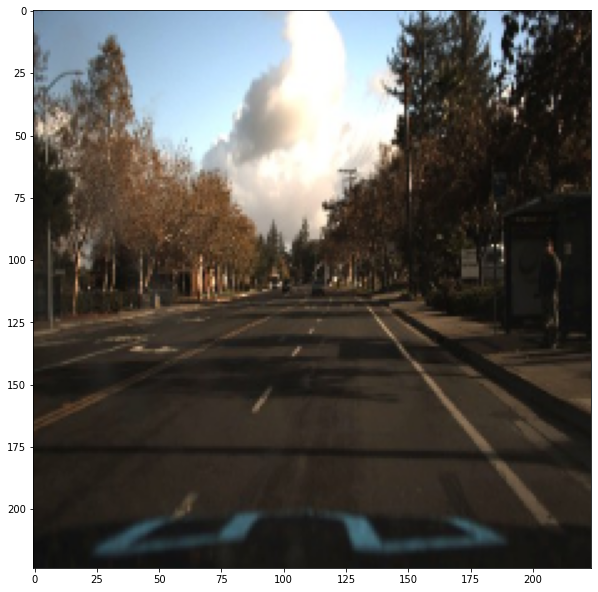

In [13]:
img1 = cv2.imread('/content/self-driving-cars/images/1478019952686311006.jpg')
img = img1.copy()
img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
img = cv2.resize(img , (224,224))
plt.figure(figsize=(10,13))
plt.imshow(img)
img1.shape

In [14]:
img_id = '1478019952686311006.jpg'
img_details = df[df['frame']==img_id]
img_details

,frame,xmin,xmax,ymin,ymax,class_id
0,1478019952686311006.jpg,237,251,143,155,1
1,1478019952686311006.jpg,437,454,120,186,3


In [17]:
df.frame

0         1478019952686311006.jpg
1         1478019952686311006.jpg
2         1478019953180167674.jpg
3         1478019953689774621.jpg
4         1478019953689774621.jpg
                   ...           
132401    1479506176491553178.jpg
132402    1479506176491553178.jpg
132403    1479506176491553178.jpg
132404    1479506176491553178.jpg
132405    1479506176491553178.jpg
Name: frame, Length: 132406, dtype: string

In [15]:
def preprocess_image(img):
  img = torch.tensor(img).permute(2,0,1)
  return img.to(device).float()

In [65]:
class SeflDrivingCarDataset(Dataset):
  w , h = 224 , 224
  def __init__(self , df  , image_root_dir = '/content/self-driving-cars/images' ):
    self.image_dir = image_root_dir
    self.df = df
    self.files = glob.glob(self.image_dir + '/*.jpg')
    self.image_infos = df.frame.unique()

  def __len__(self):
    return len(self.image_infos)

  def __getitem__(self ,ix ):
    img_id = self.image_infos[ix]
    img_path = find(img_id , self.files)
    img = Image.open(img_path).convert('RGB')
    arr_img = np.array(img)
    _h , _w , _ = arr_img.shape
    img = np.array(img.resize((self.w ,self.h) , resample = Image.BILINEAR))/255.
    data = df[df['frame'] == img_id]
    labels = data['class_id'].values.tolist()
    data = data[['xmin', 'ymin' ,'xmax' ,'ymax']].values
    data[:,[0,2]] *=  float(self.h) / _h
    data[:,[1,3]] *=  float(self.w) / _w
    boxes = data.astype(np.uint32).tolist()
    target = {}
    target["boxes"] = torch.Tensor(boxes).float()
    target["labels"] = torch.Tensor([i for i in labels]).long()
    img = preprocess_image(img)
    return img , target 

  def collate_fn(self ,batch):
    return tuple(zip(*batch))

from sklearn.model_selection import train_test_split as tts

trn_ids , val_ids = tts(df.frame.unique(),test_size =0.1,random_state =99)
trn_df , val_df = df[df['frame'].isin(trn_ids)] , df[df['frame'].isin(val_ids)]

train_ds = SeflDrivingCarDataset(trn_df)
val_ds = SeflDrivingCarDataset(val_df)

train_loader = DataLoader(train_ds , 
                          batch_size = 8, 
                          collate_fn = train_ds.collate_fn,
                          drop_last =True)

val_loader = DataLoader(val_ds , 
                        batch_size = 8,
                        collate_fn = val_ds.collate_fn,
                        drop_last =True )


In [66]:
len(train_ds) , len(val_ds)

(16200, 1800)

## Model Building 

In [37]:
import torchvision 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

def get_model():
  model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrainbed =True)
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  model.roi_heads.box_predictor = FastRCNNPredictor( in_features , 
                                                      num_classes )
  return model 

In [69]:
def train_batch(inputs, model , optimizer):
  model.train()
  input , targets = inputs 
  input = list(image.to(device) for image in input)
  targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
  optimizer.zero_grad()
  losses = model(input , targets)
  loss = sum(loss for loss in losses.values())
  loss.backward()
  optimizer.step()
  return loss , losses 

@torch.no_grad()
def validate_batch(inputs, models):
  model.train()
  input , targets = inputs 
  input = list(image.to(device) for image in input)
  targets = [{k:v.to(device) for k,v in t.items()} for t in targets]
  optimizer.zero_grad()
  losses = model(input , targets)
  loss = sum(loss for loss in losses.values())
  return loss ,losses


In [54]:
model = get_model().to(device)
optimizer = torch.optim.SGD(model.parameters() , lr=0.005 , 
                            momentum = 0.9 , weight_decay= 0.0005 )
EPOCHS = 10 

In [45]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=1e-05)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=1e-05)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=1e-05)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=1e-05)
          (relu

## Model Training 

In [47]:
loss_criterions = ['loss_classifier',
          'loss_box_reg',
          'loss_objectness',
          'loss_rpn_box_reg'] 

In [ ]:
import time 
start = time.time()
tcl , trl , tol , trpnl ,ttl = [] ,[] ,[] ,[] ,[] 
vcl , vrl , vol , vrpnl ,vtl = [] ,[] ,[] ,[] ,[] 
for epoch in range(EPOCHS):
  print(f'EPOCH {epoch+1}')
  tecl , terl , teol , terpnl ,tetl = [] ,[] ,[] ,[] ,[] 
  vecl , verl , veol , verpnl ,vetl = [] ,[] ,[] ,[] ,[]
  for ix , batch in enumerate(train_loader):
    loss , losses = train_batch(batch , model , optimizer )
    los_loss , reg_loss , loss_obj , loss_rpn_box_reg = [losses[k] for k in  loss_criterions]
    tot_loss = los_loss + reg_loss + loss_obj + loss_rpn_box_reg
    tecl.append(los_loss.detach().cpu().numpy()) , terl.append(reg_loss.detach().cpu().numpy()) , teol.append(loss_obj.detach().cpu().numpy()) 
    terpnl.append(loss_rpn_box_reg.detach().cpu().numpy()) ,tetl.append(tot_loss.detach().cpu().numpy())

  print(f'Training - Total Loss {np.mean(tetl):.5f} | Classification Loss {np.mean(tecl):.5f} | Regression Loss {np.mean(terl):.5f} ',end=" ")
  print(f'| Object Loss {np.mean(teol):.5f} | RPN Loss {np.mean(terpnl):.5f}' )
  tcl.append(np.mean(tecl)) , trl.append(np.mean(terl)) , tol.append(np.mean(teol)) , trpnl.append(np.mean(terpnl)) ,ttl.append(np.mean(tetl))


  for ix , batch in enumerate(val_loader):
    loss , losses = validate_batch(batch ,model , optimizer)
    los_loss , reg_loss , loss_obj , loss_rpn_box_reg = [losses[k] for k in  loss_criterions]
    tot_loss = los_loss + reg_loss + loss_obj + loss_rpn_box_reg
    vecl.append(los_loss.detach().cpu().numpy()) , verl.append(reg_loss.detach().cpu().numpy()) , veol.append(loss_obj.detach().cpu().numpy()) 
    verpnl.append(loss_rpn_box_reg.detach().cpu().numpy()) ,vetl.append(tot_loss.detach().cpu().numpy())
  
  print(f'Validation - Total Loss {np.mean(vetl):.5f} | Classification Loss {np.mean(vecl):.5f} | Regression Loss {np.mean(verl):.5f} ',end=" ")
  print(f'| Object Loss {np.mean(veol):.5f} | RPN Loss {np.mean(verpnl):.5f}' )

  vcl.append(np.mean(vecl)) , vrl.append(np.mean(verl)) , vol.append(np.mean(veol)) , vrpnl.append(np.mean(verpnl)) ,vtl.append(np.mean(vetl))

  print('===================================================================================================================Done')
  print()
print('                         ****************** Training Completed *****************                             ')
end = time.time()
total_time = end-start

EPOCH 1

In [ ]:
print(f'Total Time Taken : {total time}')